In [1]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision
import torch
import numpy as np
from torch import nn, optim

from model import CNN_Segmentation as model

/home/hellottie/.local/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/home/hellottie/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Load dataset

In [2]:
# Labels format
color_map = {
    (1,88,255): 0,  # sky - blue
    (156,76,30): 1,      # rough trail - brown
    (178,176,153): 2,   # smooth trail - grey
    (128,255,0): 3,      # traversable grass - light green
    (40,80,0): 4,    # high vegetation - dark green
    (0,160,0): 5,      # non-traversable low vegetation - medium green
    (255,0,128): 6,     # puddle - pink
    (255,0,0): 7,  # obstacle - red
    (255,255,255) : 8, # undefined - white
}

def convert_rgb_to_onehotencoding(label_img):
    label_np = np.array(label_img)  # (H, W, 3) - RGB
    h, w, _ = label_np.shape
    onehot = np.zeros((len(color_map), h, w), dtype=np.uint8) #uint8 as precised in the task

    for rgb, class_idx in color_map.items():
        mask = np.all(label_np == rgb, axis=-1)
        onehot[class_idx][mask] = 1

    return torch.from_numpy(onehot).float()

In [3]:
# Dataset Representation
# Dataset Representation
class ImageSegmentationTrainingDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        # because of .DS_Store presence
        self.folders = sorted([
            f for f in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, f))
        ])
        self.transform = transform

    def __len__(self):
        return len(self.folders)

    def __getitem__(self, idx):
        folder_path = os.path.join(self.root_dir, self.folders[idx])

        rgb_path = os.path.join(folder_path, 'rgb.jpg')
        label_path = os.path.join(folder_path, 'labels.png')

        rgb_image = Image.open(rgb_path).convert('RGB')
        label_image = Image.open(label_path).convert('RGB')

        label_onehotencoding = convert_rgb_to_onehotencoding(label_image)

        if self.transform:
            rgb_image = self.transform(rgb_image)
            label_image = self.transform(label_image)

        return rgb_image, label_image, label_onehotencoding

In [4]:
# Full dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = ImageSegmentationTrainingDataset(root_dir='train', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [5]:
# Data split
val_percent = 0.2
val_size = int(len(dataset) * val_percent)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

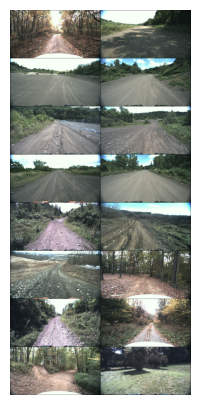

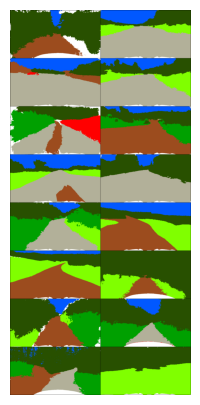

torch.Size([16, 3, 544, 1024])
torch.Size([16, 3, 544, 1024])
torch.Size([16, 9, 544, 1024])


In [6]:
# Show one batch
#"""
def show_images_batch(images):
    grid = torchvision.utils.make_grid(images, nrow=2)
    plt.figure(figsize=(10, 5))
    plt.imshow(grid.permute(1, 2, 0))  # convert (chanel, height, width) -> (height, width, channel)
    plt.axis('off')
    plt.show()

for images,labels,onehotencoding in dataloader: # for batch in batches
    show_images_batch(images)
    show_images_batch(labels)
    print(images.shape)
    print(labels.shape)
    print(onehotencoding.shape)
    break
#"""

## Model

In [7]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for rgb, _, labels in dataloader:
        rgb, labels = rgb.to(device), labels.to(device)

        # (batch, class, H, W) → targets: (batch, H, W)
        targets = labels.argmax(dim=1)

        optimizer.zero_grad()
        outputs = model(rgb)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    return running_loss / len(dataloader)

In [8]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for rgb, _, labels in dataloader:
            rgb, labels = rgb.to(device), labels.to(device)
            targets = labels.argmax(dim=1)
            print(targets.shape)
            outputs = model(rgb)
            print("outputs",outputs.shape)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [9]:
# Hyperparameters
BATCH_SIZE = 8
EPOCHS = 5
LR = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [10]:
# Loop
for epoch in range(EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

KeyboardInterrupt: 

In [ ]:
# Saves
torch.save(model.state_dict(), 'segmentation_model.pth')